In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models

## Establishing baseline accuracy
Using EfficientNetV2S, pretrained on ImageNet-1K, with all layers frozen.

What are the Top-k accuracies for:
- keyboard
- microwave
- mobile phone
- mouse
- player
- printer
- television
- washing machine

Note that {battery, PCB} cannot be tested since these categories do not appear in ImageNet-1K.

#### Load the pretrained model

In [2]:
model = EfficientNetV2S(weights='imagenet')

#### Evaluate top-k accuracies across the test set

In [3]:
# Dictionary, mapping our categories to appropriate ImageNet-1K categories
category_mapping = {
    "Keyboard": ["computer_keyboard", "typewriter_keyboard", "space_bar"],
    "Microwave": ["microwave"],
    "Mobile": ["cellular_telephone", "hand-held_computer", "iPod", "remote_control", "CD_player", "tape_player", "cassette_player", "hard_disc"],
    "Mouse": ["mouse"],
    "Player": ["cassette", "cassette_player", "tape_player", "CD_player"],
    "Printer": ["printer", "photocopier"],
    "Television": ["television", "screen", "monitor", "entertainment_center", "home_theater"],
    "Washing Machine": ["washer"]
}

results = []
total_correct = 0
total_samples = 0
for category, acceptable_labels in category_mapping.items():
    
    test_dir = "dataset2/test/" + category
    
    # Load all images into a list
    imgs = []
    for fname in os.listdir(test_dir):
        if fname.lower().endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(test_dir, fname)
            img = image.load_img(img_path, target_size=(384, 384))
            x = image.img_to_array(img)
            imgs.append(x)

    # Convert to array and preprocess
    x = np.array(imgs)
    x = preprocess_input(x)
    
    # Make predictions and evaluate top-k accuracies
    for k in [1,3,5]:
        preds = model.predict(x, batch_size=32, verbose=0)
        decoded_preds = decode_predictions(preds, top=k)
        correct = sum(any(pred[1] in acceptable_labels for pred in sample) for sample in decoded_preds)
        total = len(decoded_preds)
        # print(f"{category:20} | Top-{k} accuracy: {correct:2}/{total} = {correct/total:7.2%}")
        results.append({
            "Category": category,
            "Top-k": k,
            "Accuracy": correct/total
        })
        if k==1:
            total_correct += correct
            total_samples += total

df = pd.DataFrame(results)

##### Results (Table)

In [4]:
print(f"Overall accuracy (test set): {total_correct}/{total_samples} = {total_correct/total_samples:.3f}")

Overall accuracy (test set): 200/292 = 0.685


In [5]:
print(df.pivot(index="Category", columns="Top-k", values="Accuracy"))

Top-k                   1         3         5
Category                                     
Keyboard         0.475000  0.775000  0.825000
Microwave        0.720930  0.953488  0.976744
Mobile           0.428571  0.571429  0.595238
Mouse            0.878049  0.975610  0.975610
Player           0.666667  0.833333  0.900000
Printer          0.900000  1.000000  1.000000
Television       0.805556  0.944444  0.944444
Washing Machine  0.666667  0.800000  0.800000


##### Results (Bar Chart)

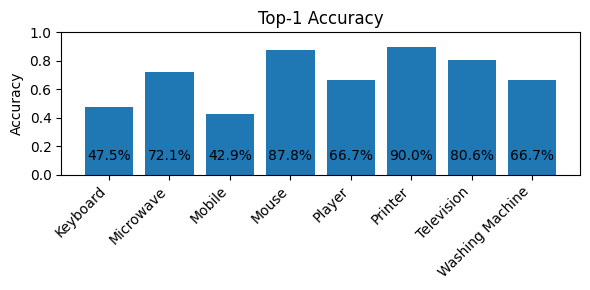

In [6]:
import matplotlib.pyplot as plt

k = 1

df_toplot = df[df["Top-k"] == k]

plt.figure(figsize=(6, 3))
plt.bar(df_toplot["Category"], df_toplot["Accuracy"])
plt.ylabel("Accuracy")
plt.title(f"Top-{k} Accuracy")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1)

# Optionally add labels on top of bars
for i, acc in enumerate(df_toplot["Accuracy"]):
    plt.text(i, 0.1, f"{acc:.1%}", ha="center")

plt.tight_layout()
plt.show()

## Transfer learning

Use EfficientNetV2S with transfer learning.

Base model: EfficientNetV2S, pretrained on ImageNet-1K, with all layers frozen. Just added a custom classification layer on top (for our e-waste categories).

#### Load train/val/test datasets

In [2]:
img_size = (384,384)   # resize to 224x224 even if dataset is 150x150
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset2/train",
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset2/val",
    image_size=img_size,
    batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset2/test",
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

class_names = train_ds.class_names
print(class_names)

train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
val_ds   =   val_ds.map(lambda x, y: (preprocess_input(x), y))
test_ds  =  test_ds.map(lambda x, y: (preprocess_input(x), y))

Found 3123 files belonging to 13 classes.
Found 377 files belonging to 13 classes.
Found 382 files belonging to 13 classes.
['Battery', 'Camera', 'Keyboard', 'Laptop', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Smartwatch', 'Television', 'Washing Machine']


#### Create the EfficientNetV2S-based model for transfer learning

In [26]:
# Base layer w/ frozen weights
base_model = EfficientNetV2S(weights="imagenet", include_top=False, input_shape=(384,384,3))
base_model.trainable = False

# Add classification head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.8),
    layers.Dense(len(class_names), activation="softmax")
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 12, 12, 1280)     20331360  
 l)                                                              
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 13)                16653     
                                                                 
Total params: 20,348,013
Trainable params: 16,653
Non-trainable params: 20,331,360
_________________________________________________________________


#### Train the model

In [27]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=3, verbose=1)

print("Test accuracy:", model.evaluate(test_ds)[1])

Epoch 1/3
98/98 [==============================] - 34s 248ms/step - loss: 1.3040 - accuracy: 0.6436 - val_loss: 0.4202 - val_accuracy: 0.9443
Epoch 2/3
98/98 [==============================] - 22s 225ms/step - loss: 0.4424 - accuracy: 0.9011 - val_loss: 0.2278 - val_accuracy: 0.9682
Epoch 3/3
12/12 [==============================] - 2s 191ms/step - loss: 0.2334 - accuracy: 0.9450
Test accuracy: 0.945026159286499


In [16]:
# model.save("EfficientNetV2S_100epochs_0p8dropout.keras")

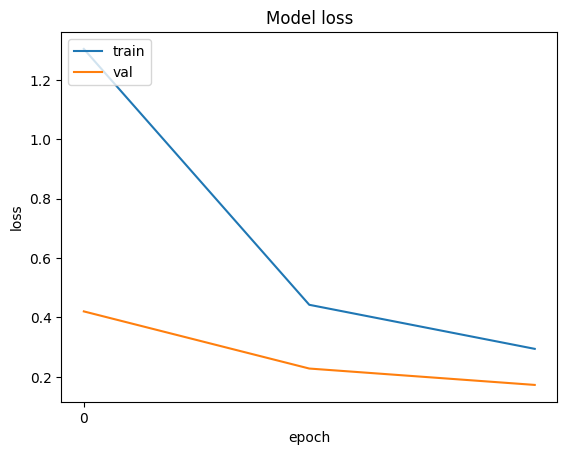

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.xticks(np.arange(0, len(history.history['loss'])+1, 10))

plt.show()

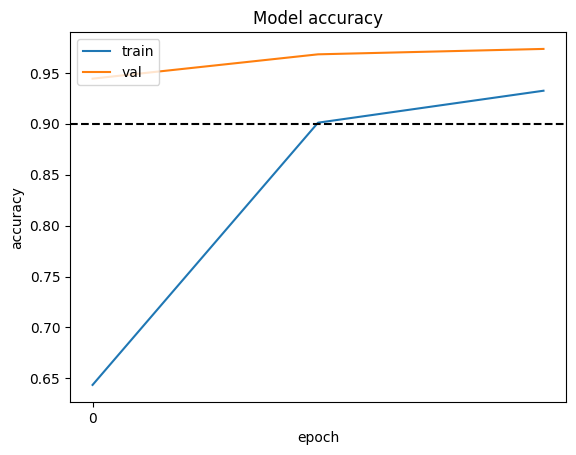

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axhline(y=0.90, color='k', linestyle='--')
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.xticks(np.arange(0, len(history.history['accuracy'])+1, 10))
# plt.ylim((0.96,1.01))

plt.show()

#### Evaluate top-k accuracies across the test set

In [3]:
model = tf.keras.models.load_model("EfficientNetV2S_100epochs_0p8dropout.keras") # Evaluating a previously trained model

In [4]:
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds, verbose=0)

results = []

for i, class_name in enumerate(class_names):
    idx = np.where(y_true == i)[0] # indices of samples in this class
    total = len(idx) # total number of samples in this class
    preds = y_pred_probs[idx] # model predictions for this class
    
    for k in [1,3,5]:
        top_k = np.argsort(preds)[:, -k:]   # top-k predicted indices
        correct = np.sum([i in row for row in top_k])
        acc = correct / total
        results.append({"Category": class_name, "Top-k": k, "Accuracy": acc})

df = pd.DataFrame(results)

##### Results (Table)

In [5]:
print(df.pivot(index="Category", columns="Top-k", values="Accuracy"))

Top-k                   1    3    5
Category                           
Battery          0.966667  1.0  1.0
Camera           0.800000  0.9  0.9
Keyboard         1.000000  1.0  1.0
Laptop           0.900000  0.9  1.0
Microwave        1.000000  1.0  1.0
Mobile           1.000000  1.0  1.0
Mouse            1.000000  1.0  1.0
PCB              1.000000  1.0  1.0
Player           0.933333  1.0  1.0
Printer          0.966667  1.0  1.0
Smartwatch       0.900000  1.0  1.0
Television       0.944444  1.0  1.0
Washing Machine  1.000000  1.0  1.0


In [6]:
acc_val = model.evaluate(val_ds, verbose=0)[1]
acc_test = model.evaluate(test_ds, verbose=0)[1]
print(f"Overall accuracy (val set): {acc_val:.3f}")
print(f"Overall accuracy (test set): {acc_test:.3f}")

Overall accuracy (val set): 0.976
Overall accuracy (test set): 0.974


##### Results (Bar Chart)

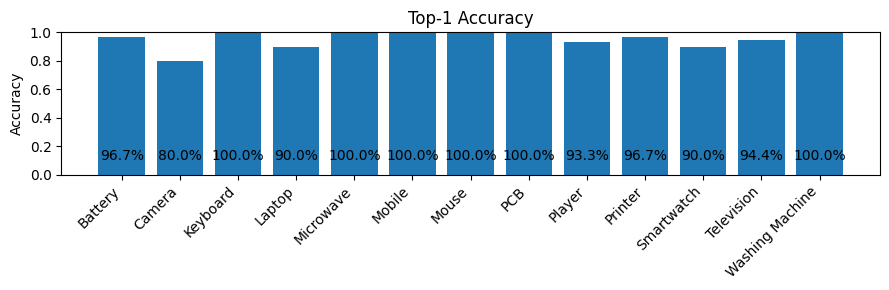

In [7]:
k = 1
df_toplot = df[df["Top-k"] == k]

plt.figure(figsize=(9, 3))
plt.bar(df_toplot["Category"], df_toplot["Accuracy"])
plt.ylabel("Accuracy")
plt.title(f"Top-{k} Accuracy")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1)  # accuracy between 0 and 1

# Optionally add labels on top of bars
for i, acc in enumerate(df_toplot["Accuracy"]):
    plt.text(i, 0.1, f"{acc:.1%}", ha="center")

plt.tight_layout()
plt.show()

#### Results - Confusion matrix

NB: this will be visually misleading w/ dataset2 (classes are imbalanced)

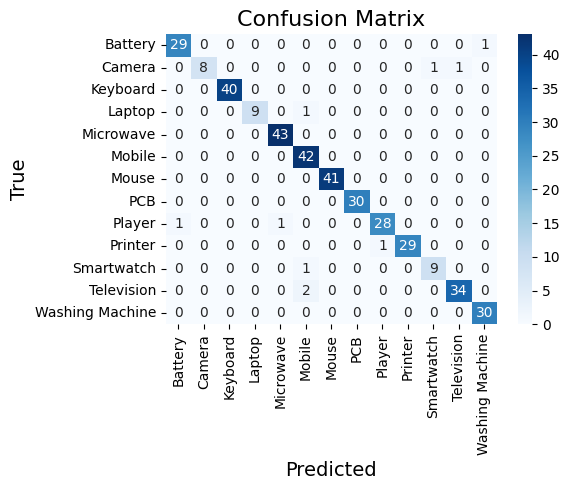

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get true labels and predictions
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
fig = plt.figure(figsize=(6, 5))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)

ax.set_xlabel('Predicted', fontsize=14)
ax.set_ylabel('True', fontsize=14)
ax.xaxis.set_ticklabels(class_names, fontsize=10, rotation=90)
ax.yaxis.set_ticklabels(class_names, fontsize=10, rotation=0)

plt.title('Confusion Matrix', fontsize=16)
plt.tight_layout()
plt.show()

#### Playing around - what's it predict some random image is?

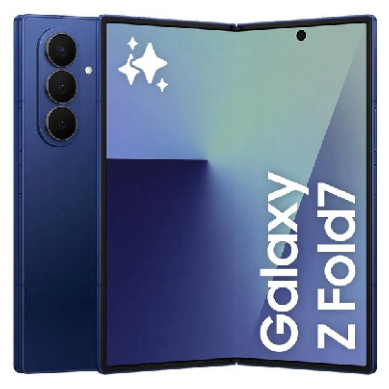

[[('<unknown>', 'Mobile', 0.52039355),
  ('<unknown>', 'Laptop', 0.30032322),
  ('<unknown>', 'Television', 0.17815308),
  ('<unknown>', 'Microwave', 0.00050280814),
  ('<unknown>', 'Mouse', 0.00037470565)]]

In [10]:
from image_classification import decode_predictions_custom

x = image.load_img('C:/Users/conor/Downloads/815595-Product-0-I-638863105202003016_600x600.webp', target_size=(384, 384))
plt.imshow(x)
plt.axis('off')
plt.show()

k=5
x = image.img_to_array(x)
x = np.expand_dims(x, axis=0)  # add batch dimension
x = preprocess_input(x)
preds = model.predict(x, verbose=0)
decoded_preds = decode_predictions_custom(preds, class_names, top=k)
decoded_preds